In [40]:
# 1. Imports & Downloads
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import correlate2d
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from os.path import basename, exists
import numpy as np
import math
import powerlaw
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
from mesa_models.boltzmann_wealth_model.model import BoltzmannWealthModel
from mesa.experimental import JupyterViz
%matplotlib inline


In [41]:
def compute_distance(pos1, pos2):
    return ((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2) ** 0.5
import random

In [42]:
class Person(Agent):
    def __init__(self, unique_id, model, decay,tribal_factor, pushback):
        super().__init__(unique_id, model)
        self.believes_rumor = False
        self.skeptical = False
        self.heard_rumor = False
        self.indifferent = False
        self.times_tried_to_convert = 0
        self.time_as_believer_or_skeptic = 0  # Time counter
        self.rumor_heard_count = 0 
        self.decay = decay
        self.tribal_factor = tribal_factor
        self.debunk = pushback
        self.update_k()
        
 
        alpha = 2.0  # Shape parameter
        xmin = 1.0   # Minimum value, adjust as needed

        # Create a power-law distribution
        pl = powerlaw.Power_Law(xmin=xmin, parameters=[alpha])

        # Optionally, you can truncate the values to a specified range (e.g., 1-5)
        self.reach =  int(np.clip(pl.generate_random(1)[0], 3, 5))




    def update_k(self):
        self.k = 1 if not self.believes_rumor else 2


    def interact_with_rumor(self, rumor):
        if self.unique_id not in rumor.known_by:
            rumor.known_by.add(self.unique_id)




    def generate_random_parameters(self, dependent_var=None, dependent_value=None):
        # Persuasive-constant: Assuming most people have moderate persuasiveness with some variation
        a = dependent_value if dependent_var == "a" else np.random.normal(0.55, 0.15)
        a = max(0.25, min(a, 0.85))  # Ensure it's within [0.25, 0.85]

        # Environmental bias: Assuming it's more likely to be around 1.1 with some variation
        E = dependent_value if dependent_var == "E" else np.random.normal(1.1, 0.2)
        E = max(0.7, min(E, 1.5))

        # Counseling of leader: Assuming most leaders have moderate counseling skills
        L = dependent_value if dependent_var == "L" else np.random.normal(0.55, 0.25)
        L = max(0.1, min(L, 1.0))

        # Social network usage: Assuming most people use social networks moderately
        sigma = dependent_value if dependent_var == "sigma" else np.random.normal(0.5, 0.2)
        sigma = max(0.1, min(sigma, 0.9))

        # Power of influencer: Assuming most influencers have power around 30 with some variation
        strength = dependent_value if dependent_var == "strength" else np.random.normal(30, 5)
        strength = max(20, min(strength, 40))

        return a, E, L, sigma, strength


    def compute_distance(self, pos1, pos2):
        """
        Compute the Euclidean distance between two positions.

        Parameters:
        - pos1: Tuple representing the (x, y) coordinates of the first position.
        - pos2: Tuple representing the (x, y) coordinates of the second position.

        Returns:
        - float: The Euclidean distance between pos1 and pos2.
        """
        return ((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2) ** 0.5

    def impact_value(self):
        """
        Compute the impact value based on the agent's position, its neighbors, and other parameters.

        Returns:
        - float: The computed impact value.
        """
        N = 200 if self.k == 1 else 300
        total = 0
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        self.a, self.E, self.L, self.sigma, self.strength = self.generate_random_parameters()
        for neighbor in neighbors:
            dij = self.compute_distance(self.pos, neighbor.pos)
            total += (self.strength / dij * self.sigma) + (self.strength / (dij ** 2) * (1 - self.sigma))
        return self.L * self.E * (N ** (self.a - 1)) * total

    def get_extended_neighbors(self, num_steps):
        """
        Retrieve the extended neighbors of the agent based on a specified number of steps.

        Parameters:
        - num_steps: Integer representing the number of steps to extend the search for neighbors.

        Returns:
        - set: A set of extended neighbors.
        """
        immediate_neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        extended_neighbors = set(immediate_neighbors)

        for step in range(num_steps):
            new_neighbors = set()
            for neighbor in immediate_neighbors:
                new_neighbors.update(self.model.grid.get_neighbors(neighbor.pos, moore=True, include_center=False))
            extended_neighbors.update(new_neighbors)
            immediate_neighbors = new_neighbors

        return extended_neighbors




    def tribalism_effect(self):
        """
        Apply the tribalism effect where the agent and all neighbors (except those 
        who have heard the rumor before) adopt the same type.
        """
        # Determine the type of the current agent
        current_type = None
        if self.believes_rumor:
            current_type = 'believer'
        elif self.skeptical:
            current_type = 'skeptic'

        # Apply the same type to all neighbors who haven't heard the rumor
        for neighbor in self.model.grid.get_neighbors(self.pos, moore=True, include_center=True):  # include_center=True to include the agent itself
            if not neighbor.heard_rumor or neighbor == self:  # Apply to neighbors who haven't heard and to the agent itself
                if current_type == 'believer':
                    neighbor.believes_rumor = True
                    neighbor.skeptical = False
                    neighbor.indifferent = False
                elif current_type == 'skeptic':
                    neighbor.believes_rumor = False
                    neighbor.skeptical = True
                    neighbor.indifferent = False
                neighbor.heard_rumor = True  # Mark the neighbor as having heard the rumor
            elif neighbor.indifferent:  # If the neighbor is indifferent
                if random.uniform(0, 1) < 0.2:  # 20% chance
                    if current_type == 'believer':
                        neighbor.believes_rumor = True
                        neighbor.skeptical = False
                        neighbor.indifferent = False
                    elif current_type == 'skeptic':
                        neighbor.believes_rumor = False
                        neighbor.skeptical = True
                        neighbor.indifferent = False


    def debunk_rumor(self):
        """
        Attempt to debunk the rumor by converting believers to skeptics among the neighbors.
        """
        for neighbor in self.model.grid.get_neighbors(self.pos, moore=True, include_center=False):
            if neighbor.believes_rumor:
                neighbor.believes_rumor = False
                neighbor.skeptical = True
    
    def spread_rumor(self):
        available_rumor_types = [rumor_type for rumor_type, agents in self.model.agents_by_type.items() if agents]
    
        # Check if there are rumors of that type
        if not available_rumor_types:
            return

        # Choose a rumor type from the available types
        rumor_type = self.random.choice(available_rumor_types)
        
        # Choose a rumor of the selected type
        rumor = self.random.choice(self.model.agents_by_type[rumor_type])
        
        # Ensure the chosen agent is indeed a Rumor
        if not isinstance(rumor, Rumor):
            return

        self.interact_with_rumor(rumor)
        


        neighbors = self.get_extended_neighbors(self.reach) if rumor.news else self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)

        if rumor.news:
            rumor.news = False
        else:
            rumor.news = True
        for neighbor in neighbors:
            if isinstance(neighbor, Person):

                
                # If the current agent is a believer or skeptic
                if self.believes_rumor or self.skeptical:
                    if neighbor.indifferent:
                        neighbor.rumor_heard_count += 1 
                        conversion_chance = 0.0005 * neighbor.rumor_heard_count ** math.exp(rumor.controversey_factor)
                
                        if random.uniform(0, 1) < conversion_chance:
                            weights = [rumor.credibility,1-rumor.credibility]
                            choice = random.choices(
                                ['believer', 'skeptic'],
                                weights= weights,  # Adjust weights as needed,
                                k=1
                            )[0]
                            if choice == 'believer':
                                neighbor.believes_rumor = True
                            else:
                                neighbor.skeptical = True
                            neighbor.indifferent = False
                            neighbor.rumor_heard_count = 0  # Reset the counter




                if self.believes_rumor:
                    # Try to spread the rumor to those who haven't heard or are indifferent
                    if not neighbor.heard_rumor or neighbor.indifferent:
                        IA = self.impact_value()
                        IB = neighbor.impact_value()
                        if rumor.complexity > 0.5:
                            IA /= np.exp(rumor.complexity - 0.5)  # Increase IA exponentially based on how much credibility exceeds 0.5
                        elif rumor.complexity <= 0.5:
                            IA *= np.exp(0.5 - rumor.complexity)  # Decrease IA exponentially based on how much credibility is below 0.5
                        if IA > IB:
                            neighbor.heard_rumor = True
                            
                            weights = [0.3, 0.3, 0.4]
                            choice = random.choices(
                                ['believer', 'skeptic', 'indifferent'],
                                weights=weights,  # Adjusted weights
                                k=1
                            )[0]
    
                            if choice == 'believer':
                                neighbor.believes_rumor = True
                            elif choice == 'skeptic':
                                neighbor.skeptical = True
                                if random.uniform(0, 1)**2 < (1-rumor.credibility) and self.debunk:
                                    self.debunk_rumor()
                            elif choice == 'indifferent':
                                neighbor.indifferent = True
                            if self.tribal_factor:
                                if self.tribal_factor > random.uniform(0, 1):
                                    self.tribalism_effect() 
                            neighbor.update_k()

                    if self.indifferent:
                        self.time_as_believer_or_skeptic = 0
                        self.indifferent = False

          

             
                          
                    


            # After interactions, believers and skeptics have a chance to become indifferent
            if self.believes_rumor or self.skeptical:
                self.time_as_believer_or_skeptic += 1
                base_chance = 0.001
           
                indifference_chance = base_chance * self.time_as_believer_or_skeptic ** np.exp(0.8*rumor.complexity+0.2*rumor.impact)
                if random.uniform(0, 1) < indifference_chance:
                    self.believes_rumor = False
                    self.skeptical = False
                    self.indifferent = True
                    self.time_as_believer_or_skeptic = 0

            
            if self.decay:
                # Check if all neighbors have heard the rumor
                all_neighbors_heard = all(neighbor.heard_rumor for neighbor in self.model.grid.get_neighbors(self.pos, moore=True, include_center=False))
                if all_neighbors_heard:
                    self.believes_rumor = False
                    self.skeptical = False
                    self.indifferent = True
                    self.time_as_believer_or_skeptic = 0




    def step(self):
        self.spread_rumor()


In [43]:
class Rumor(Agent):
    def __init__(self, unique_id, model, rumor_type,  news = False):
        super().__init__(unique_id, model)
        self.rumor_type = rumor_type
        self.credibility, self.urgency, self.impact, self.complexity = self.initial_stats(rumor_type)

        self.controversey_factor = self.urgency**2 + self.impact**2
        self.news = news
        self.known_by = set()  # Initialize the known_by attribute as an empty set

  

    def initial_stats(self, rumor_type):
    # Attributes based on rumor type
        if rumor_type == "wish":
            credibility = 0.8 if self.random.random() > 0.4 else 0.2  # Adjusted bimodal distribution
            urgency = 0.1 if self.random.random() < 0.8 else 0.9  # Power-law distribution
            impact = 0.1 if self.random.random() < 0.8 else 0.9  # Power-law distribution
            complexity = self.random.uniform(0.1, 0.3)  # Generally low with some variability

        elif rumor_type == "fear":
            credibility = 0.1 if self.random.random() < 0.5 else 0.9  # Bimodal distribution
            urgency = self.random.uniform(0.7, 0.9)  # Generally high with some variability
            impact = self.random.uniform(0.8, 1.0)  # Generally high
            complexity = self.random.uniform(0.1, 0.3)  # Adjusted to be slightly higher

        elif rumor_type == "wedge-driving":
            credibility = 0.9 if self.random.random() > 0.7 else 0.2  # Bimodal distribution
            urgency = 0.1 if self.random.random() < 0.8 else 0.9  # Power-law distribution
            impact = self.random.uniform(0.7, 0.9)  # Generally high
            complexity = self.random.uniform(0.6, 0.9)  # High complexity

        elif rumor_type == "anticipatory":
            credibility = max(0.0, min(1.0, self.random.normalvariate(0.7, 0.1)))  # Higher average credibility
            urgency = max(0.0, min(1.0, self.random.normalvariate(0.5, 0.1)))  # Mid-range urgency
            impact = self.random.uniform(0.5, 0.7)  # Slightly above average
            complexity = self.random.uniform(0.3, 0.5)  # Lower complexity


        return credibility, urgency, impact, complexity

        


In [44]:
from mesa import Model, Agent
from mesa.space import MultiGrid
from mesa.time import RandomActivation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from collections import defaultdict

class RumorModel(Model):
    def __init__(self, width, height, N, rumor_counts, news = False,decay = False, tribal_factor = False, pushback = False):
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.agents_by_type = defaultdict(list)  # Dictionary to track agents by type
        self.agents_who_know = set()
        self.track_count = []

        # Generate a shuffled list of all possible grid positions
        all_positions = [(x, y) for x in range(width) for y in range(height)]
        self.random.shuffle(all_positions)

        # Ensure we don't try to create more agents than grid cells
        N = min(N, width*height)

        # Place agents in the shuffled positions
        for i in range(N):
            agent = Person(i, self, decay, tribal_factor, pushback)
            self.schedule.add(agent)
            self.agents_by_type['Person'].append(agent)  # Add agent to the appropriate type list
            x, y = all_positions.pop()
            self.grid.place_agent(agent, (x, y))

        for rumor_type, count in rumor_counts.items():
            for _ in range(count):
                rumor_id = len(self.schedule.agents) + 1  # Dynamic ID based on current agent count
                rumor = Rumor(rumor_id, self, rumor_type, news)
                
                self.schedule.add(rumor)
                self.agents_by_type[rumor_type].append(rumor)

        # Initialize rumors based on the counts
        for rumor_type, count in rumor_counts.items():

            # Randomly select agents for each rumor type
            rumor_agents = random.sample(self.schedule.agents, count)
            
            # Set the 'believes_rumor' attribute for selected agents
            for agent in rumor_agents:
                agent.believes_rumor = True
                
                # Optionally, add the agent's unique_id to a set if needed
                self.agents_who_know.add(agent.unique_id)

    def step(self):
        self.schedule.step()
        self.track_count.append(track_person_counts(self))

        

def visualize_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    
    for content, (x, y) in model.grid.coord_iter():
        for agent in content:
            if isinstance(agent, Person):
                if agent.indifferent:
                    grid[y][x] = 1
                elif agent.believes_rumor:
                    grid[y][x] = 2
                elif agent.skeptical:
                    grid[y][x] = 3

    # Create a custom colormap
    cmap = mcolors.ListedColormap(['white', 'green', 'blue', 'red'])
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(grid, interpolation='nearest', cmap=cmap, norm=norm)
    plt.colorbar(ticks=[0.5, 1.5, 2.5, 3.5], values=[0, 1, 2, 3])
    plt.show()

def track_person_counts(model):
    person_counts = {
        "Indifferent": 0,
        "Believer": 0,
        "Skeptic": 0,
    }

    for agent in model.schedule.agents:
        if isinstance(agent, Person):
            if agent.indifferent:
                person_counts["Indifferent"] += 1
            elif agent.believes_rumor:
                person_counts["Believer"] += 1
            elif agent.skeptical:
                person_counts["Skeptic"] += 1

    return list(person_counts.values())






In [45]:

side = 200

num_agents = side**2


num_frames = 50



In [46]:
# Parameters
class Parameters():
    def __init__(self, news, decay, tribal_factor, pushback, initial_configuration):
        self.rumor_counts = {
            'wish': False,
            'fear': False,
            'wedge-driving': False,
            'anticipatory': False,
        }
        self.news = news #Expand the area that it spreads
        self.decay = decay #Become indifferent if neighbors have all heard the rumor
        self.tribal_factor = tribal_factor
        self.pushback = pushback
        self.rumor_counts[initial_configuration] = True

In [47]:

set1 = Parameters(True, True, True, True,'fear')
set2 = Parameters(True, False, True, True, 'wish')
set3 = Parameters(True, False, False, True,'wedge-driving')
set4 = Parameters(True, False, False, False,'anticipatory')
sets = [set1, set2, set3, set4]

In [48]:
def simulation(parameters):

    # Modify the visualize_grid function to get grid data
    def get_grid_data(model):
        grid = np.zeros((model.grid.width, model.grid.height))
        for content, (x, y) in model.grid.coord_iter():
            for agent in content:
                if isinstance(agent, Person):
                    if agent.indifferent:
                        grid[y][x] = 1
                    elif agent.believes_rumor:
                        grid[y][x] = 2
                    elif agent.skeptical:
                        grid[y][x] = 3
        return grid

    # Create a new function to update the animation
    def update(num):
        model.step()
        ax.clear()
        grid = get_grid_data(model)
        im = ax.imshow(grid, interpolation='nearest', cmap=cmap, norm=norm)
        # Set title with the current frame number
        ax.set_title(f"Rumor Spread Animation - Frame {num + 1}")



        return im,

    # Create the initial figure and axis
    fig, ax = plt.subplots()

    # Create colormap
    cmap = mcolors.ListedColormap(['white', 'green', 'blue', 'red'])
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    model = RumorModel(side, side, num_agents, parameters.rumor_counts, news = parameters.news, decay = parameters.decay, tribal_factor=parameters.tribal_factor, pushback = parameters.pushback)

    ani = FuncAnimation(fig, update, frames=num_frames, repeat=False)
    plt.close(ani._fig)
    
    return [HTML(ani.to_jshtml()), model]

In [49]:
sets = [simulation(s) for s in sets]

In [ ]:
sets[0]

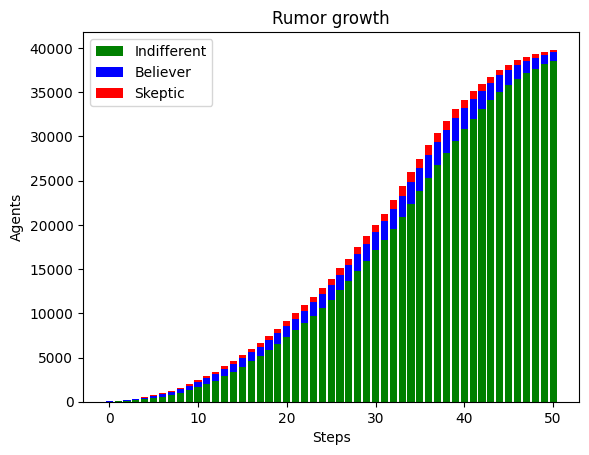

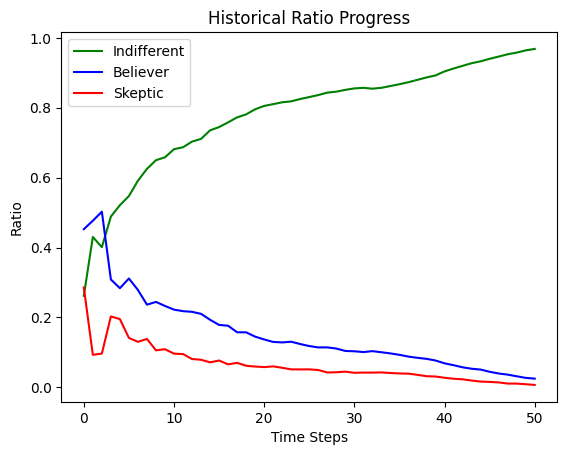

In [ ]:
import matplotlib.pyplot as plt
colors = ['green', 'blue', 'red']
labels = ['Indifferent','Believer','Skeptic']
def plot_stacked_bar(model):
    # Transpose the data
    transposed_data = list(map(list, zip(*model.track_count)))

    # Define colors for the bars
    colors = ['green', 'blue', 'red']
    
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create a stacked bar plot
    bottom = [0] * len(transposed_data[0])
    for i, values in enumerate(transposed_data):
        ax.bar(range(len(values)), values, bottom=bottom, color=colors[i], label=labels[i])
        bottom = [sum(x) for x in zip(bottom, values)]

    # Set labels and legend
    ax.set_xlabel('Steps')
    ax.set_ylabel('Agents')
    ax.set_title('Rumor growth')
    ax.legend()

    # Show the plot
    plt.savefig('fear_bar.png')
    plt.show()
   


def plot_ratio_progress(model):
    # Transpose the data
    transposed_data = list(map(list, zip(*model.track_count)))

    # Calculate the sum for each time step
    total_counts = [sum(values) for values in zip(*transposed_data)]

    # Calculate the ratio for each color
    ratios = [[value/total for value, total in zip(values, total_counts)] for values in transposed_data]


    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the ratios
    for i, ratio in enumerate(ratios):
        ax.plot(ratio, label=labels[i], color=colors[i])

    # Set labels and legend
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Ratio')
    ax.set_title('Historical Ratio Progress')
    ax.legend()

    # Show the plot
    plt.savefig('fear_ratio.png')
    plt.show()

# Sample usage
# plot_stacked_bar(model)
# plot_ratio_progress(model)

